# <div align="center"> 花 </div>

In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,pandas,matplotlib,sklearn,torch,torchvision

CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
pandas 1.0.4
matplotlib 3.2.1
sklearn 0.23.1
torch 1.6.0.dev20200609+cu101
torchvision 0.7.0.dev20200609+cu101


In [2]:
import pandas as pd  
import argparse      
import shutil        
import os            
import random
import numpy as np
import json
import math
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from IPython.display import display
from PIL import Image

from k12libs.utils.nb_dataset import k12ai_compute_mean_std

In [3]:
dataset = 'rfruits'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)
train_path = os.path.join(data_root, 'train')
test_path = os.path.join(data_root, 'test')

## 生成train.json, val.json, test.json文件

In [4]:
train_files = {}
val_files = {}
test_files = {}
names_list = []
record_count = 0 
with os.scandir(train_path) as it:
    for label, entry in enumerate(it):
        if not entry.is_dir():
            break
        test_dir = os.path.join(test_path, entry.name)
        if not os.path.exists(test_dir):
            break
            
        names_list.append(entry.name)
            
        train_files[label] = []
        val_files[label] = []
        test_files[label] = []
        
        # train
        with os.scandir(entry.path) as train_it:
            tmp_files = []
            for train_entry in train_it:
                tmp_files.append(train_entry.path)
            random.shuffle(tmp_files)
            record_count += len(tmp_files)
            val_files[label] = tmp_files[:100]
            train_files[label] = tmp_files[100:]
            print(f'train.{entry.name}:\t', len(train_files[label]))
            print(f'val.{entry.name}:\t', len(val_files[label]))
            
        # test
        with os.scandir(test_dir) as test_it:
            for test_entry in test_it:
                test_files[label].append(test_entry.path)
            record_count += len(test_files[label])
            print(f'test.{entry.name}:\t', len(test_files[label]))

train.Banana:	 390
val.Banana:	 100
test.Banana:	 166
train.Pear:	 392
val.Pear:	 100
test.Pear:	 164
train.Lemon:	 392
val.Lemon:	 100
test.Lemon:	 164
train.Apple:	 392
val.Apple:	 100
test.Apple:	 164
train.Orange:	 379
val.Orange:	 100
test.Orange:	 160


In [5]:
def generate_json_file(data, file):
    prefix_len = len(data_root)
    items = []
    for label, paths in data.items():
        for p in paths:
            items.append({'image_path': p[prefix_len+1:], 'label': label})
    random.shuffle(items)
    with open(os.path.join(data_root, file), 'w') as fp:
        json.dump(items, fp)
    
generate_json_file(train_files, 'train.json')
generate_json_file(val_files, 'val.json')
generate_json_file(test_files, 'test.json')

## 演示

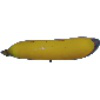

In [6]:
Image.open(train_files[0][0])

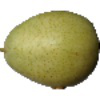

In [7]:
Image.open(train_files[1][0])

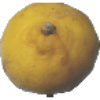

In [8]:
Image.open(train_files[2][0])

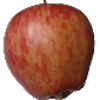

In [9]:
Image.open(train_files[3][0])

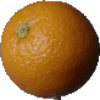

In [10]:
Image.open(train_files[4][0])

## 生成info.json

In [11]:
jfiles = ['train.json', 'val.json', 'test.json']
mean, std = k12ai_compute_mean_std(datadir=data_root, jfiles=jfiles)

In [12]:
info = {
    "records": record_count,
    "classes": names_list,
    "mean": [round(x, 4) for x in mean.numpy().tolist()],
    "std": [round(x, 4) for x in std.numpy().tolist()],
}
with open(os.path.join(data_root, 'info.json'), 'w') as fw:
    json.dump(info, fw, indent=4)

## 数据平衡分析

<Figure size 432x288 with 0 Axes>

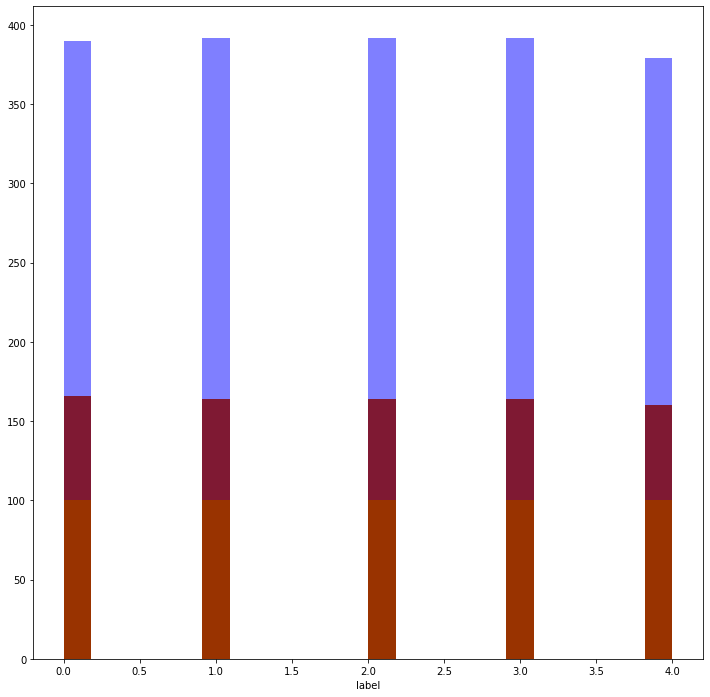

In [13]:
def draw_hist():
    plt.clf()
    fig = plt.figure(figsize=(12, 12))
    train_file = os.path.join(data_root, 'train.json')
    val_file = os.path.join(data_root, 'val.json')
    test_file = os.path.join(data_root, 'test.json')
    df_train = pd.read_json(train_file)
    df_val = pd.read_json(val_file)
    df_test = pd.read_json(test_file)
    for df, co, alpha in ((df_train, 'blue', 0.5), (df_val, 'yellow', 1), (df_test, 'maroon', 0.8)):
        sns.distplot(df['label'],
                 # fit=scipy.stats.norm,
                 kde=False,
                 hist=True,
                 hist_kws={"linewidth": 2, "alpha": alpha, 'color': co},
                 # rug=True,
                 bins=22)
    plt.savefig(f'{data_root}/labels_hist.png')
    plt.show()
draw_hist()